In [4]:
import os
dataDir = '/home/noah/Datasets'
fname = os.path.join(dataDir, 'jenaWeather.csv')

f = open(fname)
data = f.read()
f.close()


In [5]:
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [6]:
import numpy as np


floatData = np.zeros((len(lines), len(header)-1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    floatData[i,:] = values

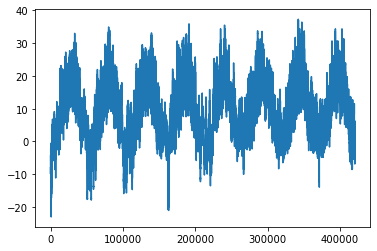

In [7]:
from matplotlib import pyplot as plt
temp = floatData[:,1]
plt.plot(range(len(temp)), temp)

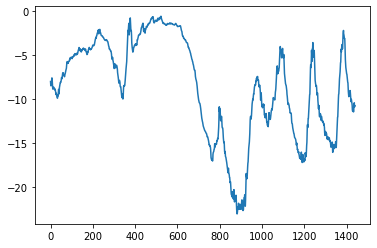

In [8]:
plt.plot(range(1440), temp[:1440])

In [9]:
loopback = 720     #Each timestamp = 10 mins so this will look back 5 days
steps  = 6         #One data point per hour
delay = 144        #Trying to predict temp in 24 hours




#Normalize data because range of temperatures have high variance and are negative/positive
mean = floatData[:200000].mean(axis=0)
floatData -= mean
std = floatData[:200000].std(axis=0)
floatData /= std

In [28]:
def generator(data,   minIndex, maxIndex,delay = 144, lookback = 1440,shuffle=False, batchSize = 128, steps = 6):
    if(maxIndex is None):
        maxIndex = len(data) - delay - 1
    i = minIndex + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(minIndex+lookback, maxIndex, size = batchSize)
        else:
            if i+batchSize>=maxIndex:
                i = minIndex+lookback
            rows = np.arrange(i,min(i+batchsize,maxIndex))
            i+=len(rows)
        samples = np.zeros((len(rows), lookback//steps, data.shape[-1]))
        targets = np.zeros((len(rows), ))
        for j,row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], steps)
            samples[j] = data[indices]
            targets[j] = data[rows[j]+delay][1]
        yield samples, targets

In [29]:
trainGen = generator(floatData, 0, 200000, shuffle=True)
valGen = generator(floatData, 200001, 300000, shuffle=True)
testGen = generator(floatData, 300000, None, shuffle=True)

In [30]:
valSteps = 300000-200001-1440
testSteps = len(floatData) - 300000-1440

In [33]:
from keras.models import Sequential
from keras.layers import GRU,Dense

model = Sequential()
model.add(GRU(32, input_shape =(None, floatData.shape[-1])))
model.add(Dense(1))
model.compile(optimizer = 'rmsprop', loss ='mae')
model.fit_generator(trainGen, steps_per_epoch=  128, epochs = 20, validation_data = valGen, validation_steps = valGen)

Epoch 1/20
128/128 [==============================] - ETA: 0s - loss: 0.3269

TypeError: '>' not supported between instances of 'int' and 'generator'